In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [131]:
import torch
torch.cuda.set_device(0)
from fastai import *
from fastai.conv_learner import *
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage

In [146]:
IMG = Path('/mnt/data/extracts/pascal/VOCdevkit/VOC2007/JPEGImages/')
STYLE_IMG = IMG/'002036.jpg'
TARGET_IMG = IMG/'003271.jpg'
!wget "https://en.wikipedia.org/wiki/File:Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg" -O "$IMG/style.jpg"
STYLE_IMG = IMG/'style.jpg'

--2018-04-28 23:33:12--  https://en.wikipedia.org/wiki/File:Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg
Resolving en.wikipedia.org (en.wikipedia.org)... 208.80.154.224, 2620:0:861:ed1a::1
Connecting to en.wikipedia.org (en.wikipedia.org)|208.80.154.224|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109721 (107K) [text/html]
Saving to: ‘/mnt/data/extracts/pascal/VOCdevkit/VOC2007/JPEGImages/style.jpg’

100%[======================================>] 109,721     --.-K/s   in 0.003s  

2018-04-28 23:33:12 (40.9 MB/s) - ‘/mnt/data/extracts/pascal/VOCdevkit/VOC2007/JPEGImages/style.jpg’ saved [109721/109721]



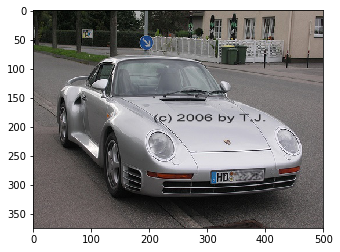

In [31]:
plt.imshow(plt.imread(TARGET_IMG)) 

In [149]:
plt.imshow(plt.imread(STYLE_IMG))

OSError: cannot identify image file '/mnt/data/extracts/pascal/VOCdevkit/VOC2007/JPEGImages/style.jpg'

In [138]:
sz = (224, 224)
model = to_gpu(vgg16(True).eval())
set_trainable(model, False)

In [147]:
def torch2npimg(img):
    return np.transpose(img, (1, 2, 0))

def np2torchimg(img):
    return np.transpose(img, (2, 0, 1))

def read_img(fpath, sz=sz):
    img = Image.open(fpath)
    img = np.asarray(img.resize(sz))/255
    return np2torchimg(img)

def plot_img(torchimg, ax=None):
    if len(torchimg.shape) == 4:
        torchimg = torchimg.squeeze()
    img = torch2npimg(to_np(torchimg))
    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(img)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
style_img = read_img(STYLE_IMG).astype('float')
target_img = read_img(TARGET_IMG).astype('float')

OSError: cannot identify image file '/mnt/data/extracts/pascal/VOCdevkit/VOC2007/JPEGImages/style.jpg'

## Convert Random Image to Target Image

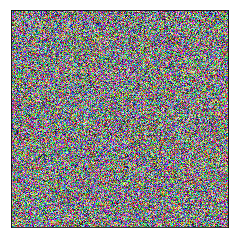

In [6]:
np.random.seed(123)
rnd_img = np.random.random((3, 224, 224)).astype('float')
plot_img(rnd_img)

In [7]:
rnd_img = V(rnd_img)
target_img = V(target_img)
rnd_img.requires_grad = True

In [8]:
def mse_loss(gen, target):
    return F.mse_loss(gen, target)

In [9]:
opt = optim.Adam([rnd_img], lr=0.001)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

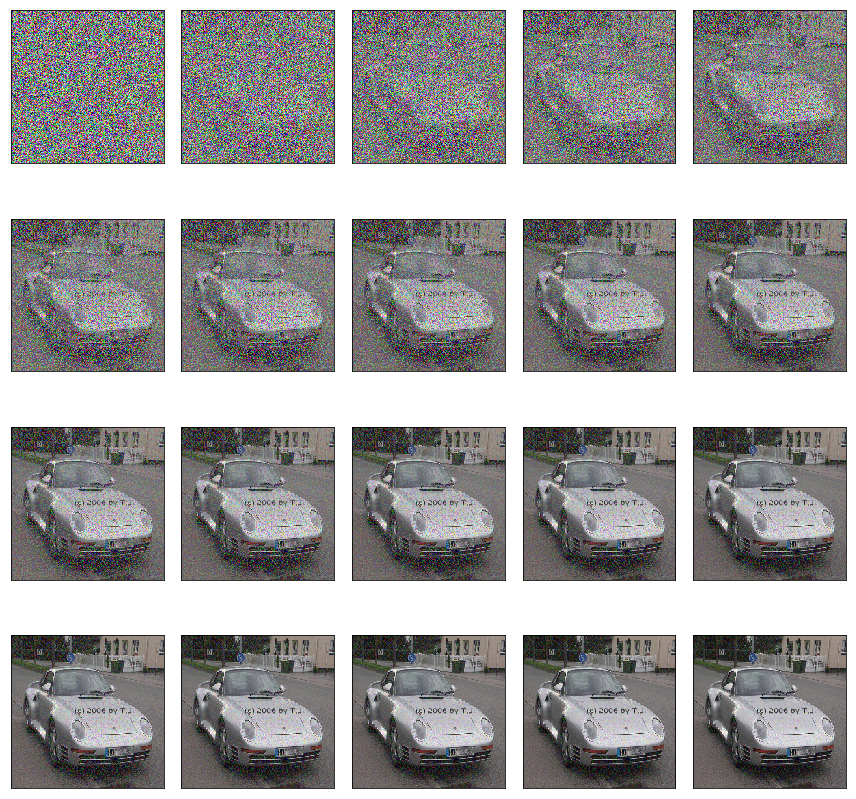

In [10]:
fig, axis = plt.subplots(4, 5, figsize=(12, 12))
plt_idx = 0
for n in range(1000):
    opt.zero_grad()
    loss = mse_loss(rnd_img, target_img)
    if n % 50 == 0:
        row = plt_idx // 5
        col = plt_idx % 5
        #pdb.set_trace()
        plot_img(rnd_img, axis[row, col])
        plt_idx += 1
    loss.backward()
    opt.step()
plt.tight_layout()

## Content Loss

In [18]:
loi = 21
inter = nn.Sequential(*list(model.children())[0:loi])
inter = to_gpu(inter).eval()
set_trainable(inter, False)

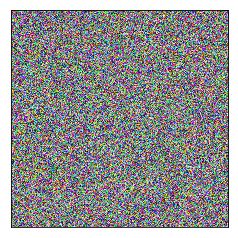

In [19]:
np.random.seed(345)
rnd_img = np.random.random((1, 3, 224, 224)).astype('float')
rnd_img = V(rnd_img)
plot_img(rnd_img)
rnd_img.requires_grad = True

In [20]:
niter = 1500
opt = optim.Adam([rnd_img])
target_act = inter(V(target_img).unsqueeze(0))

In [22]:
for n in range(niter):
    opt.zero_grad()
    gen_act = inter(rnd_img)
    loss = mse_loss(gen_act, target_act)
    loss.backward()
    opt.step()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


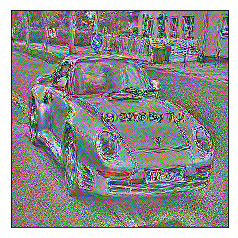

In [15]:
plot_img(rnd_img)

## Content Loss with Hooks

In [61]:
class SaveFeatures(object):
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
        
    def hook_fn(self, module, input, output):
        self.features = output
        
    def close(self):
        self.hook.remove()

In [62]:
sf = SaveFeatures(children(model)[loi])

In [63]:
loi = 21
model.eval()
set_trainable(model, False)

In [134]:
def gen_rnd_img():
    np.random.seed(345)
    rnd_img = np.random.random((3, 224, 224)).astype('float')
    rnd_img = scipy.ndimage.filters.median_filter(rnd_img, [8,8,1])
    rnd_img = np.expand_dims(rnd_img, 0)
    rnd_img = V(rnd_img)
    rnd_img.requires_grad = True
    return rnd_img

In [135]:
rnd_img = gen_rnd_img()

In [65]:
niter = 1500
opt = optim.Adam([rnd_img])
model(V(target_img).unsqueeze(0))
target_act = sf.features.clone()

In [66]:
for n in range(niter):
    opt.zero_grad()
    model(rnd_img)
    gen_act = sf.features.clone()
    loss = mse_loss(gen_act, target_act)
    loss.backward()
    opt.step()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


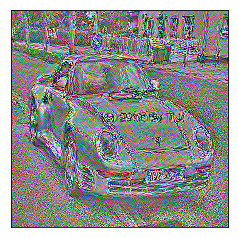

In [67]:
plot_img(rnd_img)

## Style Loss with Hooks

In [171]:
sf = [SaveFeatures(children(model)[i]) for i in [5, 12, 22, 32, 42]]

In [172]:
def gram(tens):
    tens = tens.squeeze()
    tens = tens.view(tens.shape[0], -1)
    gm = (tens @ tens.t())/tens.numel()
    return gm

In [173]:
def style_loss(gen_styles, targ_styles):
    losses = [F.mse_loss(gen_act, targ_act) 
              for gen_act, targ_act in zip(gen_styles, targ_styles)]
    return sum(losses)

In [174]:
rnd_img = gen_rnd_img()

In [175]:
niter = 1000
opt = optim.Adam([rnd_img])
model(V(np.expand_dims(style_img, 0)))
targ_styles = [l.features.clone() for l in sf]

In [176]:
for n in range(niter):
    opt.zero_grad()
    model(rnd_img)
    gen_styles = [l.features.clone() for l in sf]
    loss = style_loss(gen_styles, targ_styles)
    if n % 100 == 0:
        print(f'Iteration {n}, Loss {loss.data[0]}')
    loss.backward()
    opt.step()

Iteration 0, Loss 0.06785336136817932
Iteration 100, Loss 0.030385956168174744
Iteration 200, Loss 0.01674014702439308
Iteration 300, Loss 0.007937870919704437
Iteration 400, Loss 0.004953245632350445
Iteration 500, Loss 0.0035113899502903223
Iteration 600, Loss 0.002677001990377903
Iteration 700, Loss 0.0021508336067199707
Iteration 800, Loss 0.0017994740046560764
Iteration 900, Loss 0.0015394875081256032


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


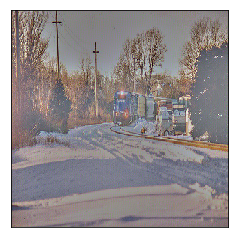

In [177]:
plot_img(rnd_img)